In [92]:
import pickle
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
sys.path.append("../../..")

from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.plotting.localization import save_localization_metadata_distance_plots


In [93]:
def load_objects(model_dir):
    # load localizers
    with open(model_dir+"/localizers.pkl", "rb") as f:
        localizers = pickle.load(f)
    # load metrics
    with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
        localizer_metrics = pickle.load(f)
    # load config 
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
    print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return localizers, localizer_metrics, model, config

In [138]:
model_dir = "../../logs/faithful-sun-1165"
localizers, localizer_metrics, model, config = load_objects(model_dir)

{'trials': 1, 'epochs': 100, 'lr': 0.001, 'batch_size': 128, 'trainer': 'triplet', 'localization_config': {'indexed': False, 'trials': 3, 'k': 1.0, 'localizer_type': 'MCMV', 'num_queries': 20}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 5, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.001, 'triplet_beta': 0.1, 'triplet_margin': 1.0, 'warm_start': 50, 'kl_max': 0.015, 'triplet_mining': False}, 'dataset_config': {'component_weighting': [0.0, 0.0, 1.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0}}


### Triplet Consistency Correlation
I want to go through and test if there is a correlation between the distance between two query choices and the probability that it is satisfied.

1. Go through a set of triplets and see if they are satisfied
2. Calculate the distance between the positive and negative value
3. Plot the distance along the x axis and have two histograms normalized by frequency, one for satisfied triplets and one for negative. 

In [139]:
# setup dataset config
dataset_config = config["dataset_config"]
which_digits = config["dataset_config"]["which_digits"]
component_weighting = config["dataset_config"]["component_weighting"]
one_two_ratio = config["dataset_config"]["one_two_ratio"]

In [140]:
# make oracle
def measure_func(image):
    if len(np.shape(image)) > 2:
        image = image[0, :, :]
    measurement = measure_image(image)
    return np.array(list(measurement))

#metadata_oracle = MetadataOracle(metadata_function=measure_func, component_weighting=component_weighting)
metadata_dataset = MetadataDataset(train=True, which_digits=which_digits)
metadata_oracle = IndexedMetadataOracle(metadata_dataset=metadata_dataset, component_weighting=component_weighting)

In [141]:
# make triplet dataset and oracle
triplet_dataset = TripletDataset(train=True, which_digits=which_digits, oracle=metadata_oracle, one_two_ratio=one_two_ratio)

In [142]:
# go through each triplet and see if it is satisfied
is_satisfied_list = []
distance_between_pos_neg = []
satisfied_margin = []
for num_iter in range(10):
    print(num_iter)
    for triplet_index in range(len(triplet_dataset)):
        (anchor, positive, negative), _ = triplet_dataset[triplet_index]
        # embed these values in latent space
        anchor_mean = model.encode(anchor.to("cuda"))[0].detach().cpu().numpy()
        positive_mean = model.encode(positive.to("cuda"))[0].detach().cpu().numpy()
        negative_mean = model.encode(negative.to("cuda"))[0].detach().cpu().numpy()
        # see if they are satisfied
        anchor_positive_dist = np.linalg.norm(anchor_mean - positive_mean)
        anchor_negative_dist = np.linalg.norm(anchor_mean - negative_mean)
        satisfied_margin.append(anchor_negative_dist - anchor_positive_dist)
        positive_negative_dist = np.linalg.norm(positive_mean - negative_mean)
        is_satisfied = anchor_positive_dist < anchor_negative_dist
        # add to list
        is_satisfied_list.append(is_satisfied)
        distance_between_pos_neg.append(positive_negative_dist)

0
1
2
3
4
5
6
7
8
9


In [132]:
# reformat the data for plotting
satisfied_distances = []
unsatisfied_distances = []
for index, is_satisfied in enumerate(is_satisfied_list):
    distance = distance_between_pos_neg[index]
    if is_satisfied:
        satisfied_distances.append(distance)
    else:
        unsatisfied_distances.append(distance)

In [ ]:
print(len(satisfied_distances)/(len(satisfied_distances) + len(unsatisfied_distances)))

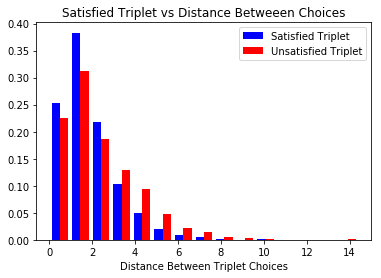

In [101]:
# plot a two bar histogram with the distance along the x axis and have
# two histograms normalized by frequency, one for satisfied triplets and one for negative.
n_bins = 15

fig, axs = plt.subplots(1, 1)

colors = ['blue', 'red']
labels = ["Satisfied Triplet", "Unsatisfied Triplet"]
axs.hist([satisfied_distances, unsatisfied_distances], n_bins, density=True, histtype='bar', color=colors, label=labels)
axs.legend(prop={'size': 10})
axs.set_title('Satisfied Triplet vs Distance Betweeen Choices')
axs.set_xlabel("Proportion")
axs.set_xlabel("Distance Between Triplet Choices")

plt.show()

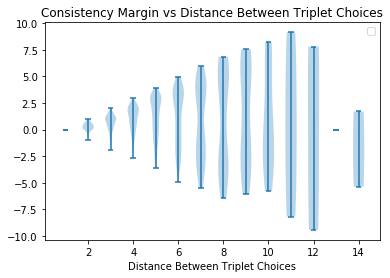

In [102]:
# show how much the triplet is satisfied by
# Show distance between triplet classes on the x
# Show the the negative - positive distance on the y
# plot a two bar histogram with the distance along the x axis and have
# two histograms normalized by frequency, one for satisfied triplets and one for negative.
n_bins = 15

fig, axs = plt.subplots(1, 1)

colors = ['blue', 'red']
labels = ["Satisfied Triplet", "Unsatisfied Triplet"]
# rounded_vals
bins = list(np.arange(0, 13))
binned_indices = np.digitize(distance_between_pos_neg, bins, right=False)
binned_values = [[] for bin_val in bins]
binned_values.append([])

for i, bin_val in enumerate(binned_indices):
    binned_values[bin_val].append(satisfied_margin[i])
for i, bin_list in enumerate(binned_values):
    if len(binned_values[i]) == 0:
        binned_values[i] = [0]
# plot violin plot
axs.violinplot(binned_values)
axs.legend(prop={'size': 10})
axs.set_title('Consistency Margin vs Distance Between Triplet Choices')
axs.set_xlabel("Consistency Margin")
axs.set_xlabel("Distance Between Triplet Choices")

plt.show()

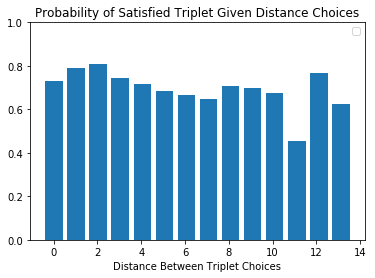

In [137]:
# plot the probability that a query is satisfied over distance
# plot a two bar histogram with the distance along the x axis and have
# two histograms normalized by frequency, one for satisfied triplets and one for negative.
n_bins = 14

fig, axs = plt.subplots(1, 1)

colors = ['blue']
labels = ["Satisfied Triplet", "Unsatisfied Triplet"]
# reformat the data for plotting
# bucket satisfied and unsatisfied
satisfied_hist, bin_edges = np.histogram(satisfied_distances, bins=n_bins)
unsatisfied_hist, bin_edges = np.histogram(unsatisfied_distances, bins=n_bins)
sum_hist = satisfied_hist + unsatisfied_hist
probability_satisfied = satisfied_hist / sum_hist
axs.bar(bin_edges[:-1], probability_satisfied)
axs.legend(prop={'size': 10})
axs.set_title('Probability of Satisfied Triplet Given Distance Choices')
axs.set_xlabel("Proportion")
axs.set_xlabel("Distance Between Triplet Choices")
axs.set_ylim(0, 1)

plt.show()